In [1]:
import matplotlib.pyplot as plt
import torch
import os
import logging
import scanpy as sc
import random
import numpy as np
import scvi as scvi

/opt/homebrew/Caskroom/mambaforge/base/envs/scvi-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0
/opt/homebrew/Caskroom/mambaforge/base/envs/scvi-env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/homebrew/Caskroom/mambaforge/base/envs/scvi-env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [2]:
logger = logging.getLogger("scvi.inference.autotune")
logger.setLevel(logging.WARNING)


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    scvi.settings.seed = seed # scvi-tools seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
seed=42
set_seed(seed)

Global seed set to 42


In [4]:
# For saving data
outputFolder = "../output/scVI/"
integrationTitle = "Pluripotent_GPC"

In [5]:
adata = sc.read_h5ad(
    "../output/H5AD/mergedH.h5ad")


In [6]:
adata.obs["orig.ident"].unique()

array(['GOL-2512A5', 'GOL2976A5', 'Sample_32', 'Sample_33', 'Sample_34',
       'Sample_C27_CD140_3', 'Sample_C27_DAPI_3', 'Sample_C27_Shi',
       'Sample_C27_undiff_1', 'Sample_CD-140', 'Sample_CD140_WA09_5',
       'Sample_unsorted', 'Sample_Unsorted_WA09_5', 'Sample_WA09_Shiv',
       'Sample_WA09_undiff_1'], dtype=object)

In [7]:
adata.obs["capture"] = adata.obs["orig.ident"]

In [8]:
target_conditions = ["Sample_C27_DAPI_3", "Sample_Unsorted_WA09_5", 'Sample_C27_CD140_3', "Sample_CD140_WA09_5", "Sample_C27_undiff_1", "Sample_WA09_undiff_1"]

In [9]:
adata = adata[adata.obs['orig.ident'].isin(target_conditions)].copy()

In [10]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

In [11]:
### Currently used 3000
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    span = .5, 
    batch_key= "line"
)

In [12]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["line"],
    continuous_covariate_keys=["percent.mt"]
)

In [13]:
model = scvi.model.SCVI(adata)

In [14]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [15]:
model.train(use_gpu=False)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/mambaforge/base/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 158/158: 100%|██| 158/158 [46:43<00:00, 16.90s/it, loss=1.79e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=158` reached.


Epoch 158/158: 100%|██| 158/158 [46:43<00:00, 17.74s/it, loss=1.79e+03, v_num=1]


In [16]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

In [17]:
print(outputFolder+integrationTitle+"_Model")

../output/scVI/Pluripotent_GPC_Model


In [18]:
model.save(outputFolder+integrationTitle+"_Model")


In [19]:
# If model is already trained load here
model = scvi.model.SCVI.load(outputFolder+integrationTitle+"_Model", adata)

INFO     File ../output/scVI/Pluripotent_GPC_Model/model.pt already downloaded                                     


In [20]:
adata.obsm["X_scVI"] = model.get_latent_representation()

In [21]:
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

In [22]:
# 250
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors = 250, random_state=seed)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [23]:
# min_dist = .1.2, spread = 1.2
sc.tl.umap(adata, min_dist = 1.2, random_state=seed, spread = 1.2)

/opt/homebrew/Caskroom/mambaforge/base/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/homebrew/Caskroom/mambaforge/base/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/homebrew/Caskroom/mambaforge/base/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


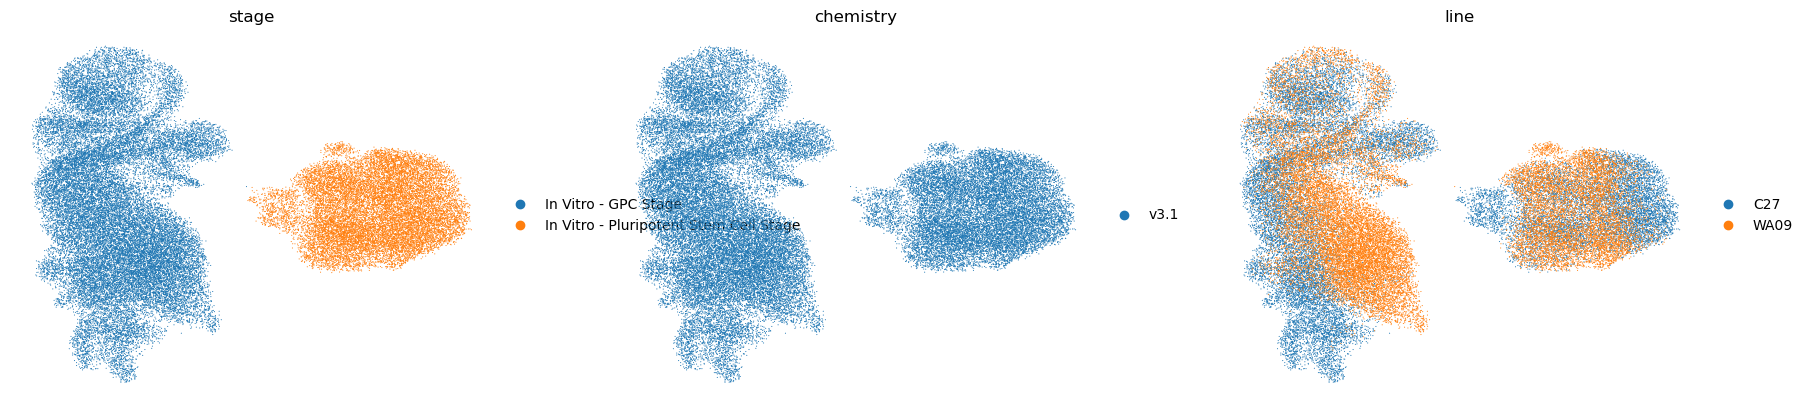

In [24]:
#1
sc.pl.umap(
    adata,
    color=["stage", "chemistry", "line"],
    frameon=False
)

/opt/homebrew/Caskroom/mambaforge/base/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


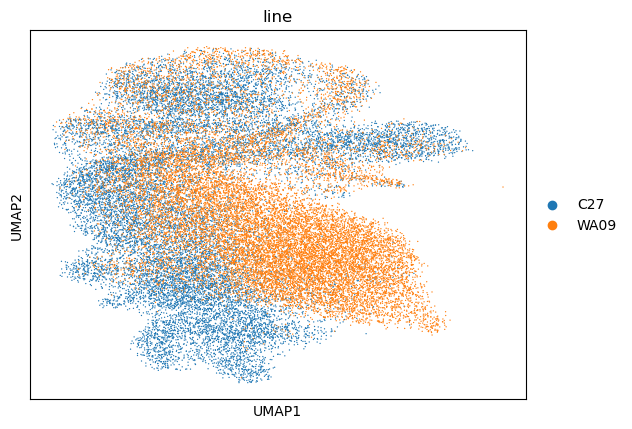

In [25]:
sc.pl.umap(
    adata[adata.obs["stage"] == "In Vitro - GPC Stage"],
    color = ["line"], 
)

/opt/homebrew/Caskroom/mambaforge/base/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


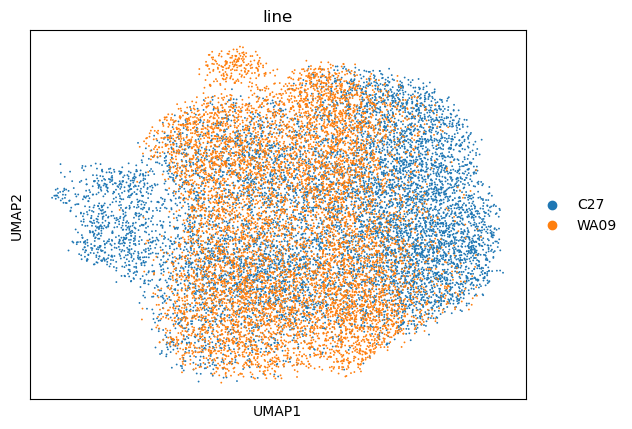

In [26]:
sc.pl.umap(
    adata[adata.obs["stage"] == "In Vitro - Pluripotent Stem Cell Stage"],
    color = ["line"], 
)

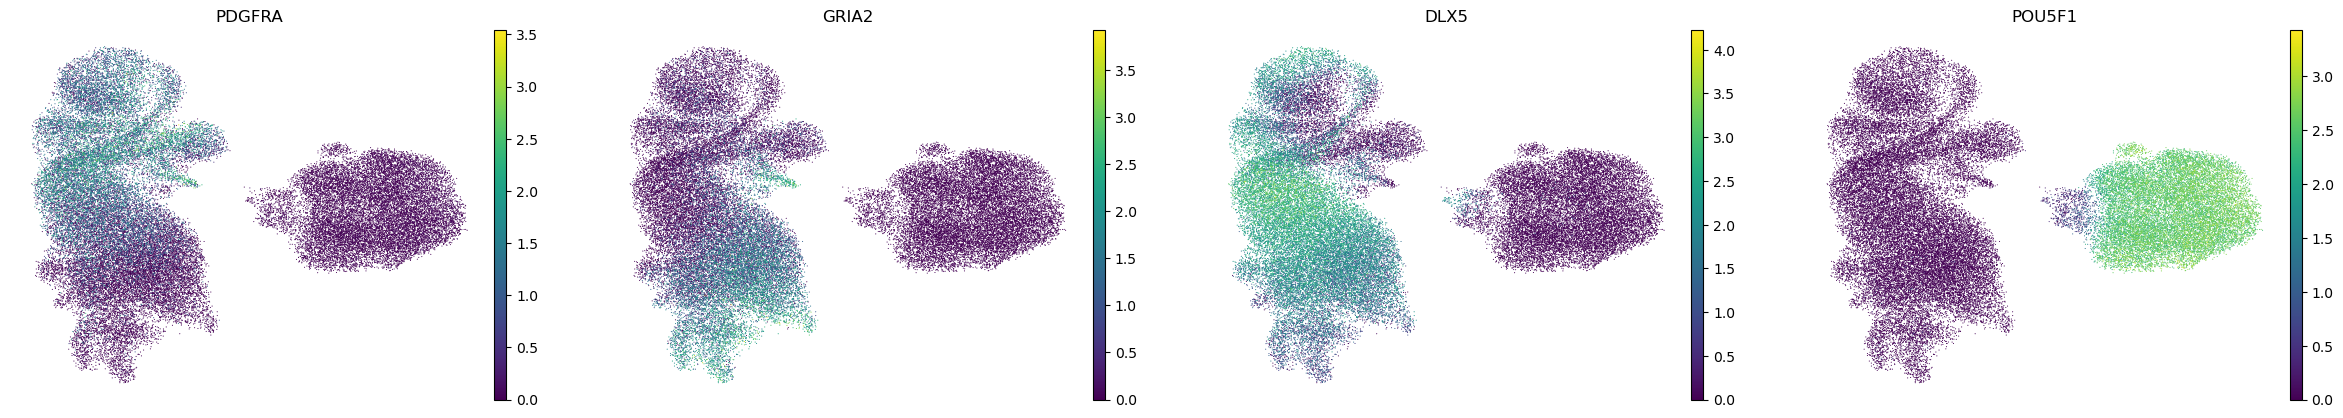

In [27]:
#1
sc.pl.umap(
    adata,
    color=["PDGFRA", "GRIA2", "DLX5", "POU5F1"],
    frameon=False
)

In [28]:
# .35
sc.tl.leiden(adata, key_added="leiden_scVI", resolution= .35)



/opt/homebrew/Caskroom/mambaforge/base/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


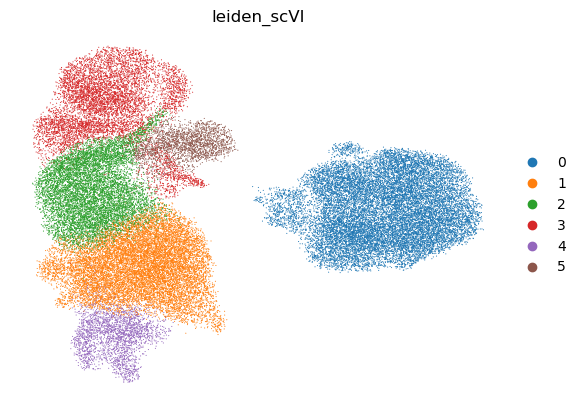

In [29]:
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    frameon=False
)

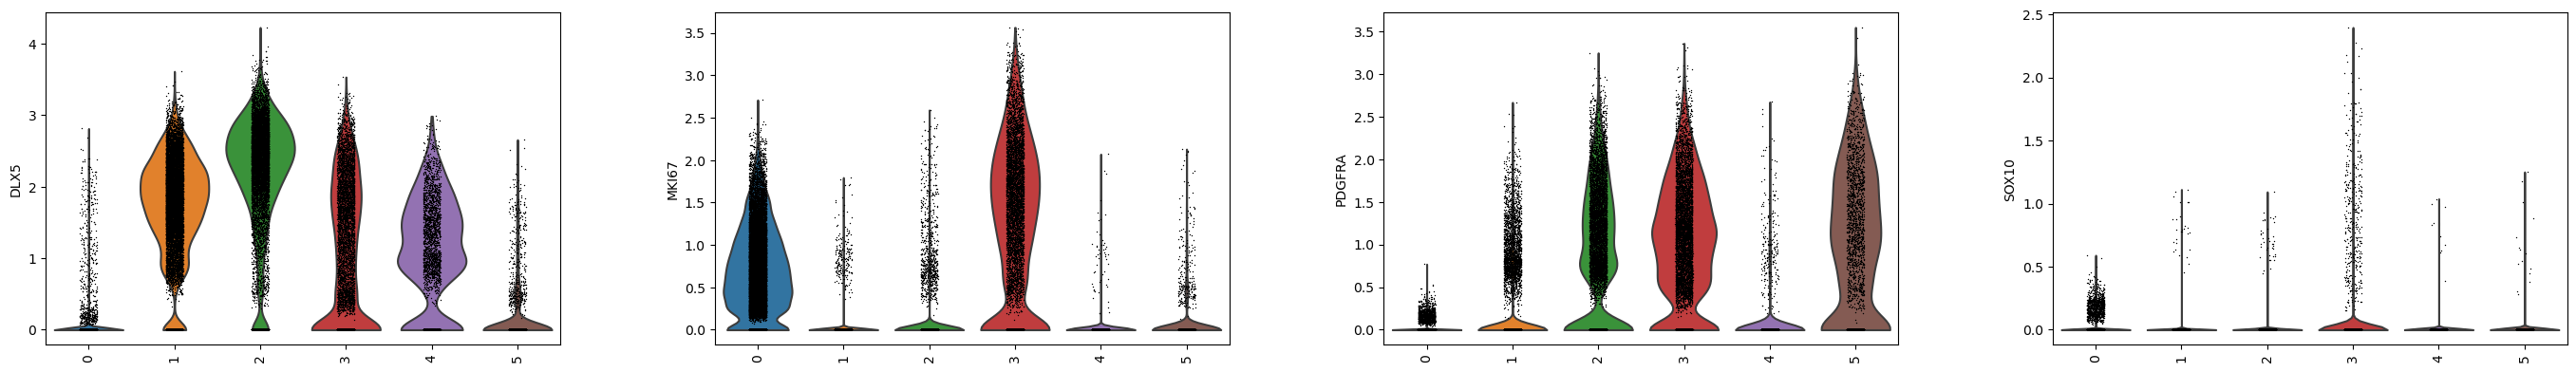

In [30]:
sc.pl.violin(adata, keys = ["DLX5", "MKI67", "PDGFRA", "SOX10"], groupby="leiden_scVI", rotation = 90)

In [31]:
## Write out adata
adata.write(outputFolder+integrationTitle+".h5ad")


In [32]:
## Save umap coordinates
np.savetxt(outputFolder+integrationTitle+"_umapEmbeddings.csv", adata.obsm["X_umap"], delimiter=",")

In [33]:
## Save leiden clusters
adata.obs["leiden_scVI"].to_csv(outputFolder+integrationTitle+"_leiden.csv")


In [34]:
sc.__version__

'1.9.3'

In [35]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

torch==1.13.1
logging==0.5.1.2
scanpy==1.9.3
numpy==1.23.5
scvi==0.20.3
